In [1]:
import pandas as pd #Analysis 
import matplotlib.pyplot as plt #Visulization

import re, string, unicodedata
import nltk
import inflect
from bs4 import BeautifulSoup
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer

from keras.preprocessing.text import Tokenizer

from nltk.stem import PorterStemmer 
from nltk.tokenize import word_tokenize
from tqdm import tqdm 

Using TensorFlow backend.


In [2]:
import numpy as np
import pandas as pd
from scipy import stats
import os
import re


df = pd.read_csv('../Pharmacovigilance_from_social_media/tweets_dataset.csv', names = ["index", "text"])
df.head()

,index,text
0,0,i am buying spy put amd leaving dsx alone that...
1,1,if my psychiatrist forgets to call in my adder...
2,3,i wa da person on xanax i ain have nun to lose
3,6,came from being a xanax addict to a bad as bit...
4,7,what is going on with violent and super sleazy...


In [3]:
del df['index']
df.head()

,text
0,i am buying spy put amd leaving dsx alone that...
1,if my psychiatrist forgets to call in my adder...
2,i wa da person on xanax i ain have nun to lose
3,came from being a xanax addict to a bad as bit...
4,what is going on with violent and super sleazy...


In [4]:
df.head(3)

,text
0,i am buying spy put amd leaving dsx alone that...
1,if my psychiatrist forgets to call in my adder...
2,i wa da person on xanax i ain have nun to lose


In [5]:
df.describe(include="all")

,text
count,149568
unique,145637
top,are antidepressant depressing you lexapro paxi...
freq,267


In [6]:
# It's going through all the data so this may take a minute. 
# I've deviated from and improved this process a lot in my other workbooks on this dataset. 
# THIS WAS MY GOSH DARN FIRST ATTEMPT SO BE KIND. :)

def standardize_text(df, text_field):
    df[text_field] = df[text_field].str.replace(r"http\S+", "")
    df[text_field] = df[text_field].str.replace(r"http", "")
    df[text_field] = df[text_field].str.replace(r"(\d)", "")
    df[text_field] = df[text_field].str.replace(r"@\S+", "")
    df[text_field] = df[text_field].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")
    df[text_field] = df[text_field].str.replace(r"@", "at")
    df[text_field] = df[text_field].str.lower()
    return df

df_clean_text = standardize_text(df, "text")

# Save locally. 
df_clean_text.to_csv("clean_data.csv", index=False)
print('Saved file clean_data.csv to your local drive')

# Save to Google Drive
#df_clean_text.to_csv("clean_data.csv")
#uploaded = drive.CreateFile({'title': "clean_data.csv"})
#uploaded.SetContentFile("clean_data.csv")
#uploaded.Upload()
#print('Uploaded file clean_data.csv with ID {}'.format(uploaded.get('id')))

df_clean_text.head(3)

Saved file clean_data.csv to your local drive


,text
0,i am buying spy put amd leaving dsx alone that...
1,if my psychiatrist forgets to call in my adder...
2,i wa da person on xanax i ain have nun to lose


In [7]:
# Just to be sure it saved, I'll read it back and check that it looks right.
# This can be used as a Checkpoint to comeback to so we don't have to re-standardize again. 
df_clean_text = pd.read_csv("clean_data.csv")
df_clean_text.tail(4)

,text
149564,off a xanax have some drunk sex
149565,i ve heard he had an adderall and cocaine prob...
149566,si vous avez de la vaisselle faire appelez m...
149567,portuguese is like spanish in xanax de verdad


In [8]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have" }

In [9]:
punct = "/-'?!.,#$%\'()*+-/:;<=>@[\\]^_`{|}~" + '""“”’' + '∞θ÷α•à−β∅³π‘₹´°£€\×™√²—–&'

In [10]:
def known_contractions(embed):
    known = []
    for contract in contraction_mapping:
        if contract in embed:
            known.append(contract)
    return known

In [13]:
punct_mapping = {"‘": "'", "₹": "e", "´": "'", "°": "", "€": "e", "™": "tm", "√": " sqrt ", "×": "x", "²": "2", "—": "-", "–": "-", "’": "'", "_": "-", "`": "'", '“': '"', '”': '"', '“': '"', "£": "e", '∞': 'infinity', 'θ': 'theta', '÷': '/', 'α': 'alpha', '•': '.', 'à': 'a', '−': '-', 'β': 'beta', '∅': '', '³': '3', 'π': 'pi', }

In [14]:
def clean_special_chars(text, punct, mapping):
    for p in mapping:
        text = text.replace(p, mapping[p])
    
    for p in punct:
        text = text.replace(p, f' {p} ')
    
    specials = {'\u200b': ' ', '…': ' ... ', '\ufeff': '', 'करना': '', 'है': ''}  # Other special characters that I have to deal with in last
    for s in specials:
        text = text.replace(s, specials[s])
    
    return text

In [15]:
df_clean_text['text'] = df_clean_text['text'].apply(lambda x: clean_special_chars(x, punct, punct_mapping))

27.274156236628155
152


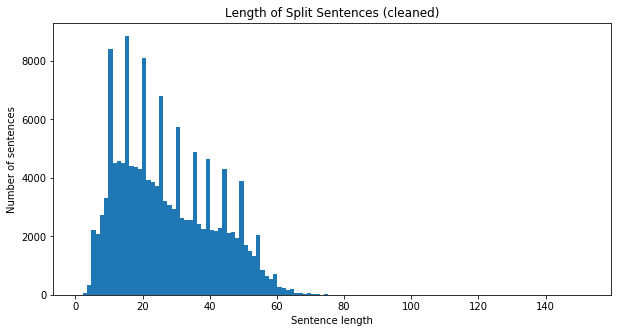

In [16]:
# I like this method so I keep coming back to it often.

print(df_clean_text['text'].str.split().str.len().mean())
print(df_clean_text['text'].str.split().str.len().max())
df_clean_text["strlen"] = df_clean_text['text'].str.split().str.len()
df_clean_text["text"] = df_clean_text['text'].str.lower()
df_clean_text.describe()

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 5)) 
plt.xlabel('Sentence length')
plt.ylabel('Number of sentences')
plt.title('Length of Split Sentences (cleaned)')
plt.hist(df_clean_text["strlen"], bins=120)
plt.show()

In [17]:
def drug_name(text):
    
    drugName = np.nan
    if 'adderall' in text:
        drugName = 'Adderall'
    elif 'prozac' in text: 
        drugName = 'Prozac'
    elif 'xanax' in text:
        drugName = 'Xanax'
    elif 'Adderall' in text:
        drugName = 'Adderall'
    elif 'Prozac' in text: 
        drugName = 'Prozac'
    elif 'Xanax' in text:
        drugName = 'Xanax'
        
    return drugName    

In [18]:
# Import NLTK stopwords. 
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/saeedahmadgill/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [19]:
# Extend the english stopwords file to include our drug stopwords. 

print ("NLTK stopword list length: ",len(stopwords),'words')
stopwords.extend(['adderall','prozac''xanax'])
print ("Added custom stopwords")
print ("New stopword list length: ",len(stopwords),'words')

NLTK stopword list length:  179 words
Added custom stopwords
New stopword list length:  181 words


In [20]:
# Google 20k most common english words to make sure drug & condition stopwords are pure. 
# https://github.com/first20hours/google-10000-english

# my Windows pc doesn't have wget working right now, but it does have a GTX-1080Ti. 
# So I'll download this manually.
#!wget = https://raw.githubusercontent.com/first20hours/google-10000-english/master/20k.txt
words_common = "20k.txt"

words_common = [line.strip() for line in open("20k.txt", 'r')]
print ("loaded words_common")

loaded words_common


In [21]:
# Extend the english stopwords file to include our drug stopwords. 

print ("NLTK stopword list length: ",len(stopwords),'words')
stopwords.extend(['adderall','prozac''xanax'])
print ("Added custom stopwords")
print ("New stopword list length: ",len(stopwords),'words')

NLTK stopword list length:  181 words
Added custom stopwords
New stopword list length:  183 words


In [22]:
# Tokenize the text
# This takes a few seconds

tokenizer = RegexpTokenizer(r'\w+')
df_clean_text["tokens"] = df_clean_text["text"].apply(tokenizer.tokenize)
df_clean_text.head()

,text,strlen,tokens
0,i am buying spy put amd leaving dsx alone that...,24,"[i, am, buying, spy, put, amd, leaving, dsx, a..."
1,if my psychiatrist forgets to call in my adder...,19,"[if, my, psychiatrist, forgets, to, call, in, ..."
2,i wa da person on xanax i ain have nun to lose,12,"[i, wa, da, person, on, xanax, i, ain, have, n..."
3,came from being a xanax addict to a bad as bit...,24,"[came, from, being, a, xanax, addict, to, a, b..."
4,what is going on with violent and super sleazy...,19,"[what, is, going, on, with, violent, and, supe..."


In [23]:
# Features BEFORE normalizing & removing stopwords

all_words = [word for tokens in df_clean_text["tokens"] for word in tokens]
df_clean_text["tokens_len"] = [len(tokens) for tokens in df_clean_text["tokens"]]
VOCAB = sorted(list(set(all_words)))
print("%s tokens in total, with a vocabulary size of %s" % (len(all_words), len(VOCAB)))

3966768 tokens in total, with a vocabulary size of 126452


In [25]:
# Define normalization function

#https://www.kdnuggets.com/2018/03/text-data-preprocessing-walkthrough-python.html
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def replace_numbers(words):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    p = inflect.engine()
    new_words = []
    for word in words:
        if word.isdigit():
            new_word = p.number_to_words(word)
            new_words.append(new_word)
        else:
            new_words.append(word)
    return new_words

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopwords:
            new_words.append(word)
    return new_words

def stemming(words):
    ps = PorterStemmer() 
    """stemming words using NLTK"""
    new_words = []
    for word in words:
        ps.stem(word)
        new_words.append(word)
    return new_words

def normalize(words):
    words = remove_non_ascii(words)
    words = remove_punctuation(words)
    words = replace_numbers(words)
    words = remove_stopwords(words)
    return words
  
# I could have gone further with this to lemmatize or stem these words but this is good for now. 


In [26]:
# ClEAN TOKENS!!!
# This takes a long time
# TDQM helps with monitoring this process while running long for loops.

# Apply Normalization and word 
df_clean_text['old_tokens'] = df_clean_text["tokens"]
df_clean_text['tokens'] = [normalize(token) for token in tqdm(df_clean_text["tokens"])]

# Save a copy locally. 
df_clean_text.to_csv("cleaned_normalized_data.csv")
print('Uploaded file clean_data.csv')

# Save copy of normalized df to google drive.
# Refresh auth if needed

#auth.authenticate_user()
#gauth = GoogleAuth()
#gauth.credentials = GoogleCredentials.get_application_default()
#drive = GoogleDrive(gauth)

#df_clean_text.to_csv("cleaned_normalized_data.csv")
#uploaded = drive.CreateFile({'title': "cleaned_normalized_data.csv"})
#uploaded.SetContentFile("cleaned_normalized_data.csv")
#uploaded.Upload()
#print('Uploaded file clean_data.csv with ID {}'.format(uploaded.get('id')))

100%|██████████| 149568/149568 [00:19<00:00, 7702.47it/s]


Uploaded file clean_data.csv


In [27]:
df_clean_text["drugName"] = df_clean_text["text"].apply(drug_name)

In [28]:
df_clean_text["drugName"].isna().sum() 

19735

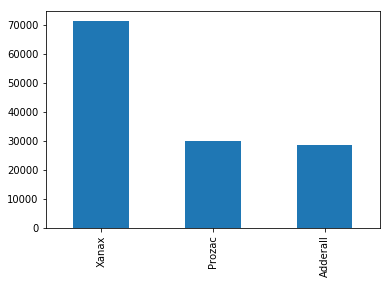

In [29]:
df_clean_text["drugName"].value_counts().plot.bar()

In [30]:
df_clean_text.head(15)

,text,strlen,tokens,tokens_len,old_tokens,drugName
0,i am buying spy put amd leaving dsx alone that...,24,"[buying, spy, put, amd, leaving, dsx, alone, l...",24,"[i, am, buying, spy, put, amd, leaving, dsx, a...",Prozac
1,if my psychiatrist forgets to call in my adder...,19,"[psychiatrist, forgets, call, im, flipping, tf...",19,"[if, my, psychiatrist, forgets, to, call, in, ...",Adderall
2,i wa da person on xanax i ain have nun to lose,12,"[wa, da, person, xanax, nun, lose]",12,"[i, wa, da, person, on, xanax, i, ain, have, n...",Xanax
3,came from being a xanax addict to a bad as bit...,24,"[came, xanax, addict, bad, bitch, life, togeth...",24,"[came, from, being, a, xanax, addict, to, a, b...",Xanax
4,what is going on with violent and super sleazy...,19,"[going, violent, super, sleazy, democrat, vict...",19,"[what, is, going, on, with, violent, and, supe...",Adderall
5,i went to rehab last summer cuz i wa withdraw ...,18,"[went, rehab, last, summer, cuz, wa, withdraw,...",18,"[i, went, to, rehab, last, summer, cuz, i, wa,...",Xanax
6,extremely aerosmith voice im baack back on my ...,10,"[extremely, aerosmith, voice, im, baack, back,...",10,"[extremely, aerosmith, voice, im, baack, back,...",Prozac
7,this is officially an uncomfortable xanax infu...,17,"[officially, uncomfortable, xanax, infused, fr...",17,"[this, is, officially, an, uncomfortable, xana...",Xanax
8,trump is sharing his adderall,5,"[trump, sharing]",5,"[trump, is, sharing, his, adderall]",Adderall
9,he never ever not once ever taken adderall mor...,35,"[never, ever, ever, taken, moron, hed, never, ...",35,"[he, never, ever, not, once, ever, taken, adde...",Adderall


In [31]:
df_clean_text.dropna(subset=['drugName'], how='all', inplace = True)

In [32]:
df_clean_text["drugName"].isna().sum() 

0

In [33]:
df_clean_text.head(3)

,text,strlen,tokens,tokens_len,old_tokens,drugName
0,i am buying spy put amd leaving dsx alone that...,24,"[buying, spy, put, amd, leaving, dsx, alone, l...",24,"[i, am, buying, spy, put, amd, leaving, dsx, a...",Prozac
1,if my psychiatrist forgets to call in my adder...,19,"[psychiatrist, forgets, call, im, flipping, tf...",19,"[if, my, psychiatrist, forgets, to, call, in, ...",Adderall
2,i wa da person on xanax i ain have nun to lose,12,"[wa, da, person, xanax, nun, lose]",12,"[i, wa, da, person, on, xanax, i, ain, have, n...",Xanax


In [34]:
# Tokenize the text
# This takes a few seconds

tokenizer = RegexpTokenizer(r'\w+')
df_clean_text["tokens"] = df_clean_text["text"].apply(tokenizer.tokenize)
df_clean_text.head()

,text,strlen,tokens,tokens_len,old_tokens,drugName
0,i am buying spy put amd leaving dsx alone that...,24,"[i, am, buying, spy, put, amd, leaving, dsx, a...",24,"[i, am, buying, spy, put, amd, leaving, dsx, a...",Prozac
1,if my psychiatrist forgets to call in my adder...,19,"[if, my, psychiatrist, forgets, to, call, in, ...",19,"[if, my, psychiatrist, forgets, to, call, in, ...",Adderall
2,i wa da person on xanax i ain have nun to lose,12,"[i, wa, da, person, on, xanax, i, ain, have, n...",12,"[i, wa, da, person, on, xanax, i, ain, have, n...",Xanax
3,came from being a xanax addict to a bad as bit...,24,"[came, from, being, a, xanax, addict, to, a, b...",24,"[came, from, being, a, xanax, addict, to, a, b...",Xanax
4,what is going on with violent and super sleazy...,19,"[what, is, going, on, with, violent, and, supe...",19,"[what, is, going, on, with, violent, and, supe...",Adderall


In [35]:
# Import NLTK stopwords. 
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/saeedahmadgill/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


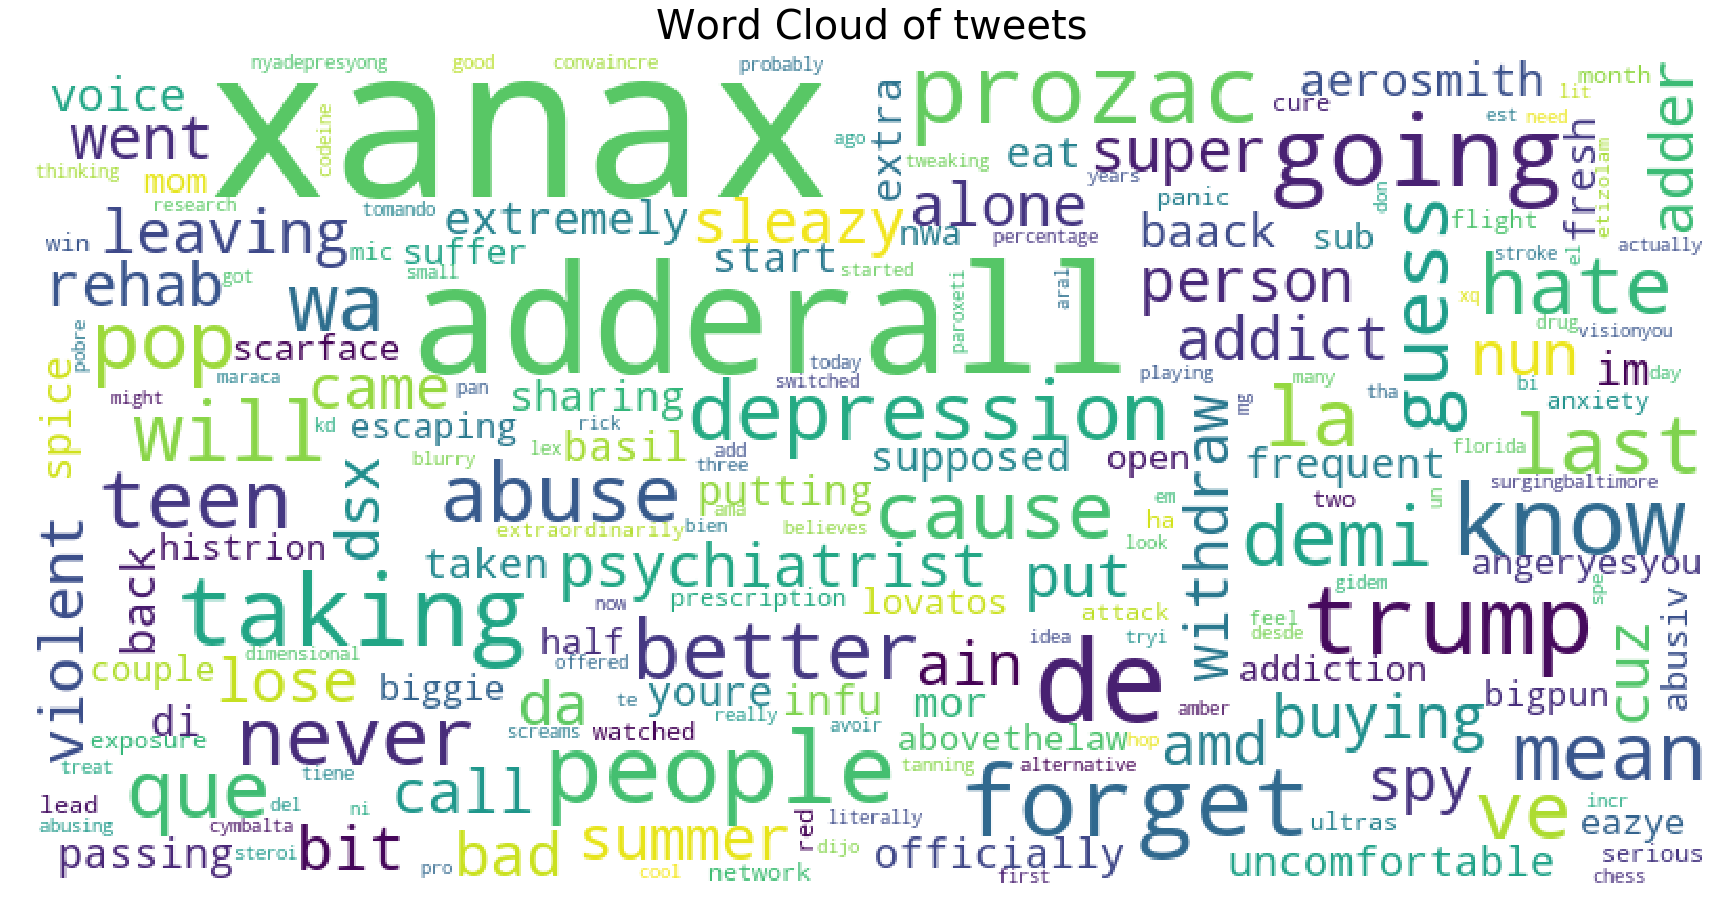

In [36]:
#https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-qiqc kernel 
from wordcloud import WordCloud, STOPWORDS

# Thanks : https://www.kaggle.com/aashita/word-clouds-of-various-shapes ##
def plot_wordcloud(text, mask=None, max_words=200, max_font_size=100, figure_size=(24.0,16.0), 
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    more_stopwords = {'one', 'br', 'Po', 'th', 'sayi', 'fo', 'Unknown'}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color='white',
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    width=800, 
                    height=400,
                    mask = mask)
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  
    
plot_wordcloud(df_clean_text["text"], title="Word Cloud of tweets")

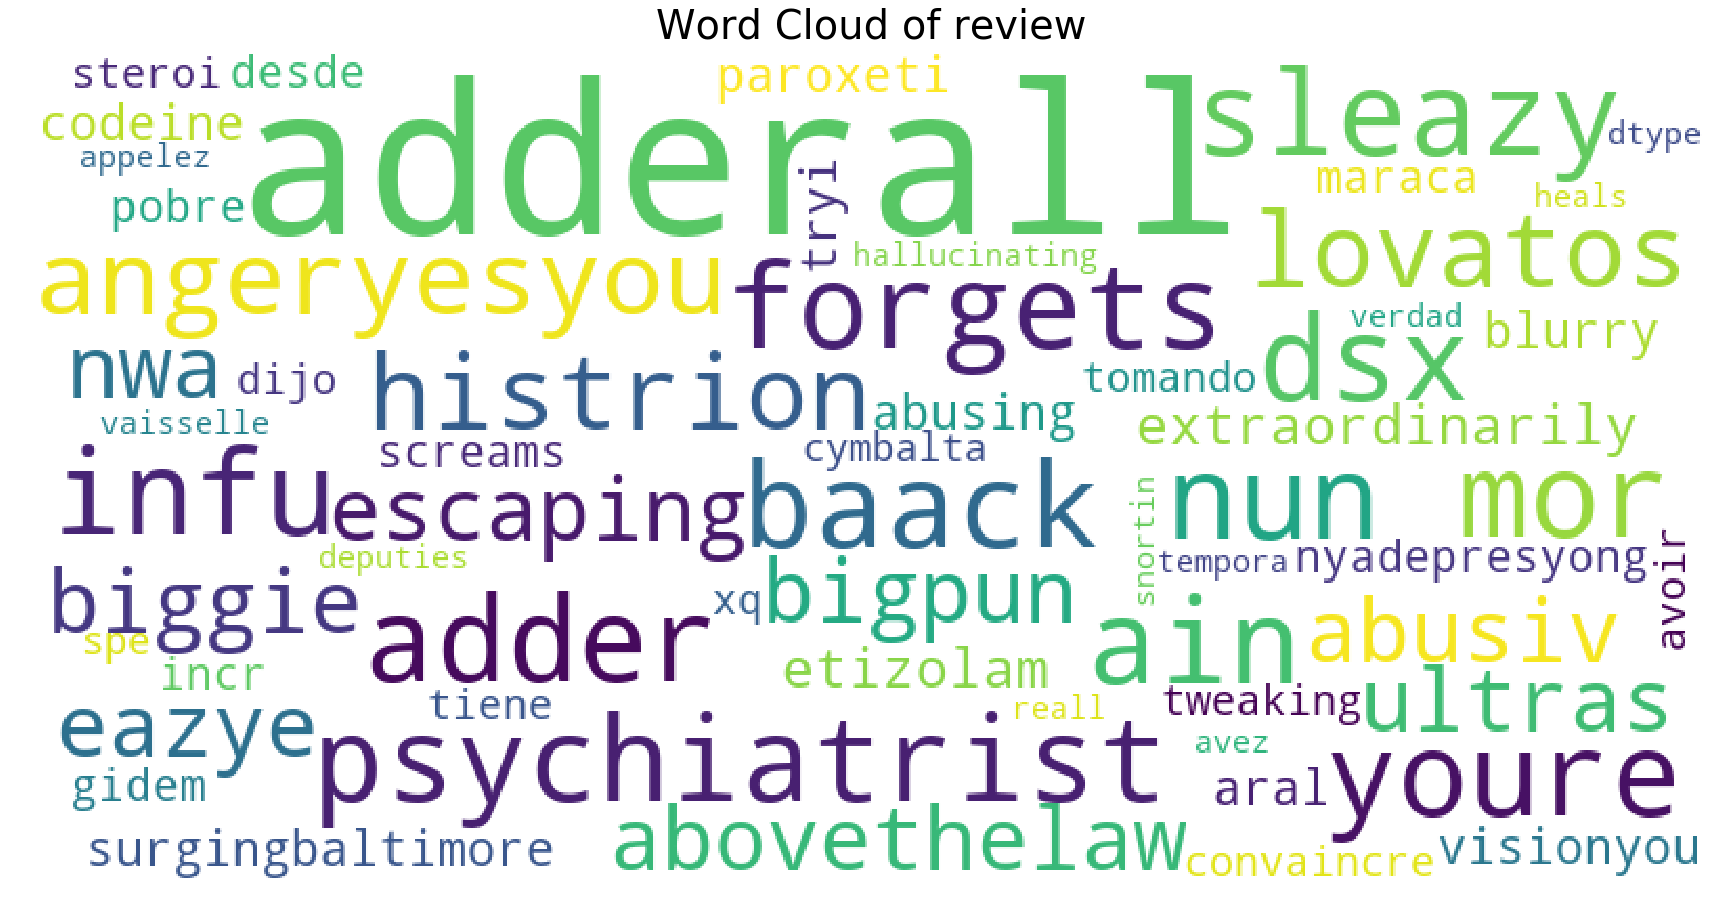

In [37]:
#https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-qiqc kernel 
from wordcloud import WordCloud, STOPWORDS

# Thanks : https://www.kaggle.com/aashita/word-clouds-of-various-shapes ##
def plot_wordcloud(text, mask=None, max_words=200, max_font_size=100, figure_size=(24.0,16.0), 
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    more_stopwords = {'one', 'br', 'Po', 'th', 'sayi', 'fo', 'Unknown'}
    stopwords = stopwords.union(words_common)

    wordcloud = WordCloud(background_color='white',
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    width=800, 
                    height=400,
                    mask = mask)
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  
    
plot_wordcloud(df_clean_text["text"], title="Word Cloud of review")

In [38]:
df_clean_text.head()

,text,strlen,tokens,tokens_len,old_tokens,drugName
0,i am buying spy put amd leaving dsx alone that...,24,"[i, am, buying, spy, put, amd, leaving, dsx, a...",24,"[i, am, buying, spy, put, amd, leaving, dsx, a...",Prozac
1,if my psychiatrist forgets to call in my adder...,19,"[if, my, psychiatrist, forgets, to, call, in, ...",19,"[if, my, psychiatrist, forgets, to, call, in, ...",Adderall
2,i wa da person on xanax i ain have nun to lose,12,"[i, wa, da, person, on, xanax, i, ain, have, n...",12,"[i, wa, da, person, on, xanax, i, ain, have, n...",Xanax
3,came from being a xanax addict to a bad as bit...,24,"[came, from, being, a, xanax, addict, to, a, b...",24,"[came, from, being, a, xanax, addict, to, a, b...",Xanax
4,what is going on with violent and super sleazy...,19,"[what, is, going, on, with, violent, and, supe...",19,"[what, is, going, on, with, violent, and, supe...",Adderall


In [39]:
df.head()

,text
0,i am buying spy put amd leaving dsx alone that...
1,if my psychiatrist forgets to call in my adder...
2,i wa da person on xanax i ain have nun to lose
3,came from being a xanax addict to a bad as bit...
4,what is going on with violent and super sleazy...


In [40]:
%matplotlib inline

from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
from collections import defaultdict

## custom function for ngram generation ##
def generate_ngrams(text, n_gram=1):
    token = [token for token in text.split(" ") if token != "" if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [" ".join(ngram) for ngram in ngrams]

## custom function for horizontal bar chart ##
def horizontal_bar_chart(df, color):
    trace = go.Bar(
        y=df["word"].values[::-1],
        x=df["wordcount"].values[::-1],
        showlegend=False,
        orientation = 'h',
        marker=dict(
            color=color,
        ),
    )
    return trace

## Get the bar chart from heigh frequency ##
freq_dict = defaultdict(int)
for sent in df["text"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(50), 'blue')

## Get the bar chart from low frequency ##
freq_dict = defaultdict(int)
for sent in df["text"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.tail(50), 'blue')

# Creating two subplots
fig = tools.make_subplots(rows=1, cols=2, vertical_spacing=0.04,
                          subplot_titles=["Frequent words heigh frequency", 
                                          "Frequent words low frequency"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig['layout'].update(height=1200, width=900, paper_bgcolor='rgb(233,233,233)', title="Word Count Plots")
py.iplot(fig, filename='word-plots')

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]



In [41]:
freq_dict = defaultdict(int)
for sent in df["text"]:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(50), 'orange')

freq_dict = defaultdict(int)
for sent in df["text"]:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace2 = horizontal_bar_chart(fd_sorted.tail(50), 'orange')

# Creating two subplots
fig = tools.make_subplots(rows=1, cols=2, vertical_spacing=0.04,horizontal_spacing=0.15,
                          subplot_titles=["Highly Frequent biagrams", 
                                          "Least Frequent biagrams"])
fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig['layout'].update(height=1200, width=1000, paper_bgcolor='rgb(233,233,233)', title="Bigram Count Plots")
py.iplot(fig, filename='word-plots')

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]



In [42]:
freq_dict = defaultdict(int)
for sent in df["text"]:
    for word in generate_ngrams(sent,3):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(50), 'green')

freq_dict = defaultdict(int)
for sent in df["text"]:
    for word in generate_ngrams(sent,3):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace2 = horizontal_bar_chart(fd_sorted.tail(50), 'green')

# Creating two subplots
fig = tools.make_subplots(rows=1, cols=2, vertical_spacing=0.04,horizontal_spacing=0.15,
                          subplot_titles=["Highly Frequent trigrams", 
                                          "Least Frequent trigrams"])
fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig['layout'].update(height=1200, width=1600, paper_bgcolor='rgb(233,233,233)', title="Trigram Count Plots")
py.iplot(fig, filename='word-plots')

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]



In [43]:
freq_dict = defaultdict(int)
for sent in df["text"]:
    for word in generate_ngrams(sent,4):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(50), 'red')

freq_dict = defaultdict(int)
for sent in df["text"]:
    for word in generate_ngrams(sent,4):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace2 = horizontal_bar_chart(fd_sorted.head(50), 'red')

# Creating two subplots
fig = tools.make_subplots(rows=1, cols=2, vertical_spacing=0.04,horizontal_spacing=0.15,
                          subplot_titles=["Highly Frequent 4-grams", 
                                          "Least Frequent 4-grams"])
fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig['layout'].update(height=1200, width=1600, paper_bgcolor='rgb(233,233,233)', title="4-grams Count Plots")
py.iplot(fig, filename='word-plots')

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]

